In [27]:
import os
from collections import defaultdict
import random

import pandas as pd
import torch

import config
from config import PATH_RESULTS_DIR
from models.model import BaseModel

from datasets.dataset import Dataset

from evaluation.eval import evaluate_model, evaluate_predictions

from models.naive_models import AverageYieldModel
from models.sklearn_model import SklearnModel
from models.nn_models import ExampleLSTM

# Autoreload modules
%load_ext autoreload
%autoreload 2


def kfold_nested_tuning(run_name: str, model_name: str, model_constructor, model_kwargs, model_fit_kwargs, n_folds=5, seed=None):
    path_results = os.path.join(PATH_RESULTS_DIR, run_name)
    os.makedirs(path_results, exist_ok=True)

    assert n_folds > 2, "n_folds must be greater than 2 for nested cross-validation"

    benchmark_models = {
        "AverageYieldModel": AverageYieldModel,
        model_name: model_constructor
    }

    models_kwargs = defaultdict(dict)
    models_fit_kwargs = defaultdict(dict)
    models_kwargs[model_name] = model_kwargs
    models_fit_kwargs[model_name] = model_fit_kwargs

    dataset = Dataset.load("test_maize_us")

    # Set seed if provided
    if seed is not None:
        random.seed(seed)
        torch.manual_seed(seed)

    # Divide all_years into 5 folds of years, by shuffling and splitting into 5 equal parts
    all_years = dataset.years
    list_all_years = list(all_years)
    random.shuffle(list_all_years)
    cv_folds = [list_all_years[i::n_folds] for i in range(n_folds)]

    # Print some information about the benchmark
    print(f"Running benchmark {run_name} with model {model_name}")
    print(f"Years: {len(all_years)}")
    print(f"CV folds: {[len(f) for f in cv_folds]}")
    print(f"CV years: {cv_folds}")

    # Define a dictionary to store the results of the benchmark
    outer_loop_results = {}

    # Outer CV loop, leave out one fold for testing
    # Define tqdm, loop over inner + outer CV
    for i, test_fold in enumerate(cv_folds):
        test_years = test_fold
        other_folds = cv_folds[:i] + cv_folds[i+1:]


        # Inner CV loop, leave out one fold for validation
        inner_loop_results = {}
        for j, val_fold in enumerate(other_folds):
            # Create train and val datasets for inner fold
            val_years = val_fold
            train_years = [y for y in all_years if y not in test_years + val_years]
            train_dataset, val_dataset = dataset.split_on_years((train_years, val_years))

            assert len(set(train_years) & set(val_years)) == 0
            assert len(set(train_years) & set(test_fold)) == 0
            print(f"Train years: {train_years}")
            print(f"Val years: {val_years}")

            # Define a dictionary to store the model output
            labels = val_dataset.targets()
            model_output = {
                config.KEY_LOC: [loc_id for loc_id, _ in val_dataset.indices()],
                config.KEY_YEAR: [year for _, year in val_dataset.indices()],
                'targets': labels,
            }

            model_results = {}
            for model_name, model_constructor in benchmark_models.items():
                model = model_constructor(**models_kwargs[model_name])
                model.fit(train_dataset, **models_fit_kwargs[model_name])
                predictions, _ = model.predict(val_dataset)
                # save predictions
                results = evaluate_predictions(labels, predictions)
                model_results[model_name] = results
            inner_loop_results[j] = model_results

        df = pd.DataFrame.from_dict(model_output)
        df.set_index([config.KEY_LOC, config.KEY_YEAR], inplace=True)
        df.to_csv(os.path.join(path_results, f'fold_{i}.csv'))

        outer_loop_results[i] = inner_loop_results
        break

    return outer_loop_results


lstm_kwargs_base = {
        'n_ts_features': 9,
        'n_static_features': 1,
        'hidden_size': 32,
        'num_layers': 3,
    }

lstm_fit_kwargs_base = {
    'batch_size': 32,
    'num_epochs': 5,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'optim_fn': torch.optim.Adam,
    'optim_kwargs': {"lr":0.001},
    'scheduler_fn': torch.optim.lr_scheduler.StepLR,
    'scheduler_kwargs': {"step_size": 2, "gamma": 0.8},
    'val_fraction': 0.0,
}

# TODO: add normalization, cv tuning to fit function
# Set batch_size to 32
# ? num_epochs to 5
# ? scheduler
# Tune LR, num_layers, hidden_size and wd
# Add normalization
# Fix combine_summaries

def summarize_results(results):
    """Converts the results of a nested cross-validation into a summary dictionary.
    The summary dictionary contains the average performance and standard deviation of each model across all inner folds for all metrics.
    The format is {model_name: {metric_name: (mean, std)}}.
    """
    # First, we will flatten the results and dict like {(outer_loop_index, inner_loop_index, model_name, metric_name): value}
    flat_results = {(i, j, model_name, metric_name): value
                    for i, inner_results in results.items()
                    for j, model_results in inner_results.items()
                    for model_name, model_metrics in model_results.items()
                    for metric_name, value in model_metrics.items()}

    # Now we can create a DataFrame from the flat results
    df = pd.DataFrame.from_dict(flat_results, orient='index')
    df.reset_index(inplace=True)
    df['outer_loop'] = df['index'].apply(lambda x: x[0])
    df['inner_loop'] = df['index'].apply(lambda x: x[1])
    df['model'] = df['index'].apply(lambda x: x[2])
    df['metric'] = df['index'].apply(lambda x: x[3])
    df['value'] = df[0]
    df.drop(columns=['index', 0], inplace=True)

    # Now we can calculate the mean and standard deviation over the inner loop
    inner_loop_mean = df.groupby(['model', 'metric'])['value'].mean()
    inner_loop_std = df.groupby(['model', 'metric'])['value'].std()

    # Finally, we store the results in a dictionary
    summary = {}
    for model in inner_loop_mean.index.levels[0]:
        summary[model] = {metric: (inner_loop_mean[model, metric], inner_loop_std[model, metric])
                          for metric in inner_loop_mean[model].index} 
    return summary



def combine_summaries(summary, new_summary, index):
    """Combines the results of a new nested cross-validation into the existing results. Names of the models cannot overlap."""

    # Remove AverageYieldModel from the new summary
    new_summary.pop("AverageYieldModel", None)

    # Rename the models in the new summary
    new_summary = {f"{index}_{model}": metrics for model, metrics in new_summary.items()}





for num_layers in [1]:
    lstm_kwargs = lstm_kwargs_base.copy()
    lstm_fit_kwargs = lstm_fit_kwargs_base.copy()
    lstm_kwargs['num_layers'] = num_layers
    results = kfold_nested_tuning(f"lstm_layers_{num_layers}", "ExampleLSTM", ExampleLSTM, lstm_kwargs, lstm_fit_kwargs, n_folds=3, seed=16)
    print(results)



IndentationError: expected an indented block (nn_models.py, line 100)

In [21]:
import os
import config
import pandas as pd

from evaluation.eval import evaluate_model, evaluate_predictions


results_path = os.path.join("C:/Users/potze002/Projects/AgML-crop-yield-forecasting/results/test_lstm_2_3_layers")

# Load the results in a dict of dfs by looping over files in dir

results = {}

for file in os.listdir(results_path):
    print(file)
    if file.endswith(".csv"):
        df = pd.read_csv(os.path.join(results_path, file))
        results[file] = df

# Combine the results into a single df
for key, df in results.items():
    

    # For columns except for loc_id, year, targets, calculate rmse, mape, pearsons r
    # Store the results in a dict of dicts like {model_name: {metric_name: (mean, std)}}
    model_results = {}
    for model_name in df.columns[3:]:
        metrics = evaluate_predictions(df['targets'], df[model_name])
        model_results[model_name] = metrics

    print(model_results)



year_2000.csv
year_2001.csv
year_2002.csv
year_2003.csv
{'AverageYieldModel': {'normalized_rmse': 19.2526746797385, 'mape': 0.18035542266194285}, 'LSTM': {'normalized_rmse': 20.783496459391557, 'mape': 0.1964203095181895}, 'LSTM_2_layers': {'normalized_rmse': 18.057249449113, 'mape': 0.16784855601353194}}
{'AverageYieldModel': {'normalized_rmse': 15.619935921899561, 'mape': 0.13495998570744433}, 'LSTM': {'normalized_rmse': 17.82196976252447, 'mape': 0.15947731317165542}, 'LSTM_2_layers': {'normalized_rmse': 19.789029966646837, 'mape': 0.1701821396945213}}
{'AverageYieldModel': {'normalized_rmse': 33.720339851962564, 'mape': 0.3669377853448524}, 'LSTM': {'normalized_rmse': 42.97112099914547, 'mape': 0.49651867187240817}, 'LSTM_2_layers': {'normalized_rmse': 41.56994249833173, 'mape': 0.4734594317174386}}
{'AverageYieldModel': {'normalized_rmse': 16.754666471282505, 'mape': 0.1650789407765569}, 'LSTM': {'normalized_rmse': 24.438252385784278, 'mape': 0.2471894015113349}, 'LSTM_2_layers': 

In [28]:
train_dataset = Dataset.load("test_maize_us")
test_dataset = Dataset.load("test_maize_us")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model, assumes that all features are in np.ndarray format
n_total_features = len(train_dataset[0].keys()) - 3
ts_features = [key for key in train_dataset[0].keys() if type(train_dataset[0][key]) == np.ndarray]
ts_features = [key for key in ts_features if len(train_dataset[0][key].shape) == 1]

model = ExampleLSTM(len(ts_features), n_total_features - len(ts_features), hidden_size=64, num_layers=2, output_size=1)
scheduler_fn = torch.optim.lr_scheduler.StepLR
scheduler_kwargs = {"step_size": 2, "gamma": 0.5}

# Train model
model.fit(  train_dataset, batch_size=3200, num_epochs=10, device=device, 
            optim_kwargs={"lr":0.01}, 
            scheduler_fn=scheduler_fn, scheduler_kwargs=scheduler_kwargs)

test_preds, _ = model.predict(test_dataset)
assert test_preds.shape[0] == len(test_dataset)

# Check if evaluation results are within expected range
evaluation_result = evaluate_model(model, test_dataset)
print(evaluation_result)

min_expected_values = {"normalized_rmse": 0, "mape": 0.00,}
for metric, expected_value in min_expected_values.items():
    assert (
        metric in evaluation_result
    ), f"Metric '{metric}' not found in evaluation result"
    assert (
        evaluation_result[metric] >= expected_value
    ), f"Value of metric '{metric}' does not match expected value"
    # Check metric is not NaN
    assert not np.isnan(evaluation_result[metric]), f"Value of metric '{metric}' is NaN"


[{'test': 1, 'optim_kwargs': {'lr': 0.001, 'weight_decay': 0.0001, 'test2': 2}, 'num_layers': 1}, {'test': 1, 'optim_kwargs': {'lr': 0.001, 'weight_decay': 0.001, 'test2': 2}, 'num_layers': 1}, {'test': 1, 'optim_kwargs': {'lr': 0.001, 'weight_decay': 0.01, 'test2': 2}, 'num_layers': 1}, {'test': 1, 'optim_kwargs': {'lr': 0.01, 'weight_decay': 0.0001, 'test2': 2}, 'num_layers': 1}, {'test': 1, 'optim_kwargs': {'lr': 0.01, 'weight_decay': 0.001, 'test2': 2}, 'num_layers': 1}, {'test': 1, 'optim_kwargs': {'lr': 0.01, 'weight_decay': 0.01, 'test2': 2}, 'num_layers': 1}, {'test': 1, 'optim_kwargs': {'lr': 0.1, 'weight_decay': 0.0001, 'test2': 2}, 'num_layers': 1}, {'test': 1, 'optim_kwargs': {'lr': 0.1, 'weight_decay': 0.001, 'test2': 2}, 'num_layers': 1}, {'test': 1, 'optim_kwargs': {'lr': 0.1, 'weight_decay': 0.01, 'test2': 2}, 'num_layers': 1}, {'test': 1, 'optim_kwargs': {'lr': 0.001, 'weight_decay': 0.0001, 'test2': 2}, 'num_layers': 2}, {'test': 1, 'optim_kwargs': {'lr': 0.001, 'weig

In [18]:
sep = '.'
k = 'optim_kwargs'

keys = k.split(sep)

if len(keys) == 1:
    print("Single key")
    print(keys)

Single key
['optim_kwargs']


In [24]:
def summarize_results(results):
    """Converts the results of a nested cross-validation into a summary dictionary.
    The summary dictionary contains the average performance and standard deviation of each model across all inner folds for all metrics.
    The format is {model_name: {metric_name: (mean, std)}}.
    """
    # First, we will flatten the results and dict like {(outer_loop_index, inner_loop_index, model_name, metric_name): value}
    flat_results = {(i, j, model_name, metric_name): value
                    for i, inner_results in results.items()
                    for j, model_results in inner_results.items()
                    for model_name, model_metrics in model_results.items()
                    for metric_name, value in model_metrics.items()}

    # Now we can create a DataFrame from the flat results
    df = pd.DataFrame.from_dict(flat_results, orient='index')
    df.reset_index(inplace=True)
    df['outer_loop'] = df['index'].apply(lambda x: x[0])
    df['inner_loop'] = df['index'].apply(lambda x: x[1])
    df['model'] = df['index'].apply(lambda x: x[2])
    df['metric'] = df['index'].apply(lambda x: x[3])
    df['value'] = df[0]
    df.drop(columns=['index', 0], inplace=True)

    # Now we can calculate the mean and standard deviation over the inner loop
    inner_loop_mean = df.groupby(['model', 'metric'])['value'].mean()
    inner_loop_std = df.groupby(['model', 'metric'])['value'].std()

    # Finally, we store the results in a dictionary
    summary = {}
    for model in inner_loop_mean.index.levels[0]:
        summary[model] = {metric: (inner_loop_mean[model, metric], inner_loop_std[model, metric])
                          for metric in inner_loop_mean[model].index} 
    return summary

print(summarize_results(results))

{'AverageYieldModel': {'mape': (0.19230514921304034, 0.06509871520116), 'normalized_rmse': (19.981153646227543, 4.40718620261915)}, 'ExampleLSTM': {'mape': (0.4660354463382536, 0.12172360500429115), 'normalized_rmse': (52.96101630988483, 12.073390064135193)}}


metric                 mape  normalized_rmse
model                                       
AverageYieldModel  0.192305        19.981154
ExampleLSTM        0.466035        52.961016
metric                 mape  normalized_rmse
model                                       
AverageYieldModel  0.065099         4.407186
ExampleLSTM        0.121724        12.073390


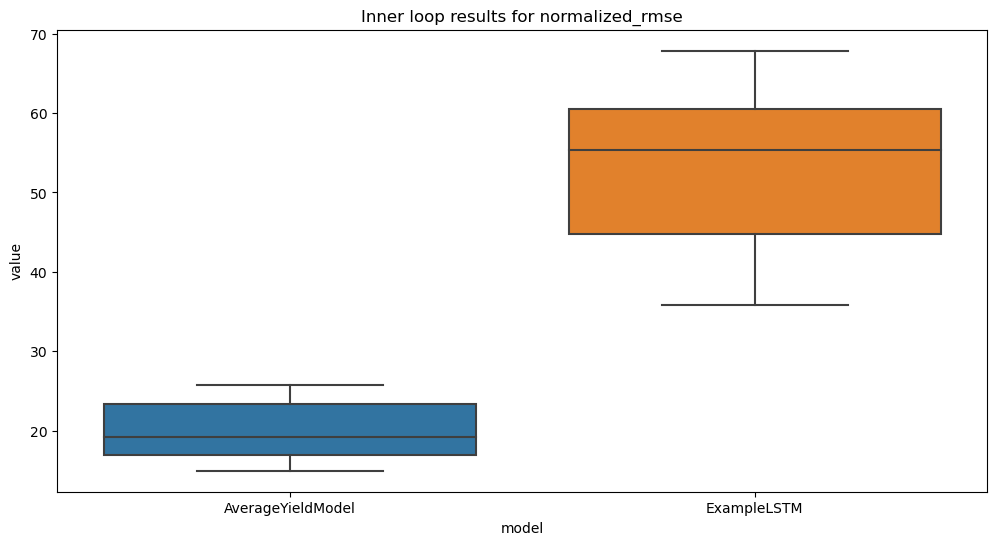

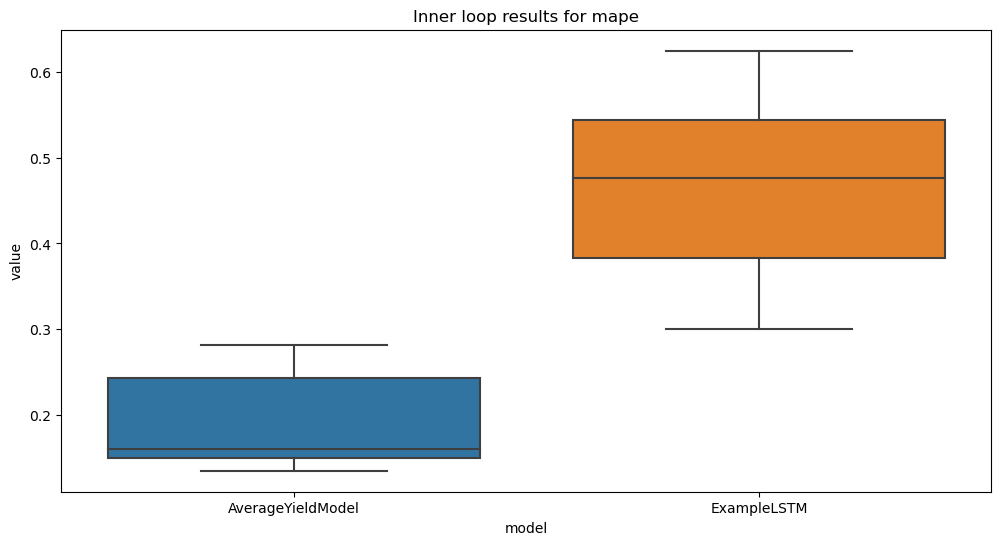

In [22]:
# Results are in nested dictionary, with outer loop index, inner loop index, model name and metric name as keys
# For each model and metric, we want to calculate the mean and standard deviation over the inner loop
# Then we want to calculate the mean and standard deviation over the outer loop
# Finally we want to print the results in a nice table

# First, we will flatten the results and dict like {(outer_loop_index, inner_loop_index, model_name, metric_name): value}
flat_results = {(i, j, model_name, metric_name): value
                for i, inner_results in results.items()
                for j, model_results in inner_results.items()
                for model_name, model_metrics in model_results.items()
                for metric_name, value in model_metrics.items()}

# Now we can create a DataFrame from the flat results
df = pd.DataFrame.from_dict(flat_results, orient='index')
df.reset_index(inplace=True)
df['outer_loop'] = df['index'].apply(lambda x: x[0])
df['inner_loop'] = df['index'].apply(lambda x: x[1])
df['model'] = df['index'].apply(lambda x: x[2])
df['metric'] = df['index'].apply(lambda x: x[3])
df['value'] = df[0]
df.drop(columns=['index', 0], inplace=True)

# Now we can calculate the mean and standard deviation over the inner loop
inner_loop_mean = df.groupby(['model', 'metric'])['value'].mean()
inner_loop_std = df.groupby(['model', 'metric'])['value'].std()

# Finally, we can print the results in a single nice table with both mean and std over the inner loop
print(inner_loop_mean.unstack())
print(inner_loop_std.unstack())

# Next we make a nice plot
import matplotlib.pyplot as plt
import seaborn as sns

# Boxplot of inner loop results
plt.figure(figsize=(12, 6))
plt.title("Inner loop results for normalized_rmse")
sns.boxplot(data=df[df['metric'] == 'normalized_rmse'], x='model', y='value')
plt.show()

# Same for mape
plt.figure(figsize=(12, 6))
plt.title("Inner loop results for mape")
sns.boxplot(data=df[df['metric'] == 'mape'], x='model', y='value')
plt.show()
